In [2]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


In [48]:
filename = 'W_a040c010_x175s002.dat' #Nx = 75, dx = 17.0/150
new_Lx = 70
N = round(new_Lx * 150/17.0)

names = ['*', '1','2','3','4','5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)

if N > 2*len(df.index): 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00]*2 + [0.00]
    rem = pd.DataFrame([rem for i in range(N-2*len(df.index))], columns=names)
    new = pd.concat([df, rem, df.iloc[::-1]], ignore_index=True)
else: 
    shave = df.iloc[:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]])
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    df.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))

Success: 618 == 618.


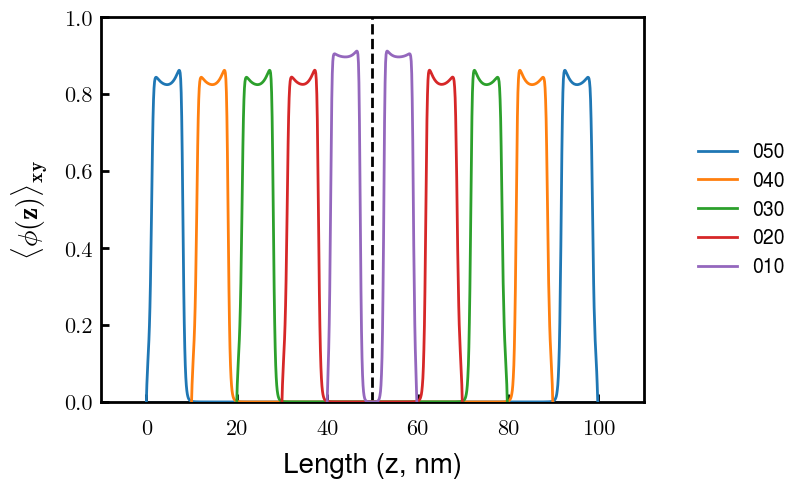

In [3]:
# SYSG
labs = ['{:03d}'.format(i) for i in np.concatenate([np.arange(50, 9, -10)],)]
read_list = [GIT+'phSYSG_a040d{}.dat'.format(i) for i in labs]
max_d = 50 #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

In [4]:
from scipy.interpolate import UnivariateSpline
freeE = pd.read_csv(GIT+'int_p1.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
d, y = freeE.lx/2, freeE.freeE
max_d = max(d)
min_d = min(d)

## Centered Finite Difference 
# dx  = d.iloc[:-1]  - d.iloc[1:].reset_index(drop=True)
# dxc = (d.iloc[:-1] + d.iloc[1:].reset_index(drop=True)) / 2
# dyc = y.iloc[:-1] - y.iloc[1:].reset_index(drop=True)
# dyc = np.divide(dyc, dx)

## Cubic Splines Interpolater
d_new = np.linspace(min_d, max_d, 1000)
f = UnivariateSpline(d, y, s=1e-8, k=3)
csfit = f(d_new)
csder = f.derivative(n=1)(d_new)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
axs[0].plot(d, y, 'o',   c='C0', label='Raw')
axs[0].plot(d_new, csfit, c='C1', label='Cubic Spline')

# axs[1].plot(dxc[0:], dyc[0:], 'o', c='C0', label='Raw cFD',alpha=0.7)
axs[1].plot(d_new, csder,   c='C1', label='Cubic Spline Der')

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

ValueError: max() arg is an empty sequence

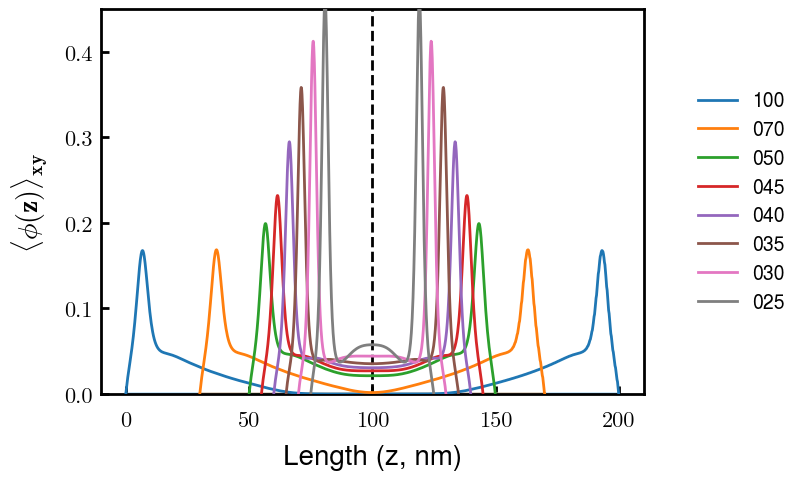

In [7]:
# NFH
# labs = ['{:03d}'.format(i) for i in np.concatenate([np.arange(100, 49, -10), [48], np.arange(44, 34, -1)])]
# labs = ['{:03d}'.format(i) for i in np.concatenate([np.arange(44, 34, -1)])]
labs = ['100', '070', '050', '045', '040', '035', '030', '025']
read_list = [GIT+'ph_a020d{}.dat'.format(i) for i in labs]
max_d = 100 #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=0.45, labs=labs, double=False, show=False)
                       # x1_start = 100, x1_end=350, y1_end=0.50, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

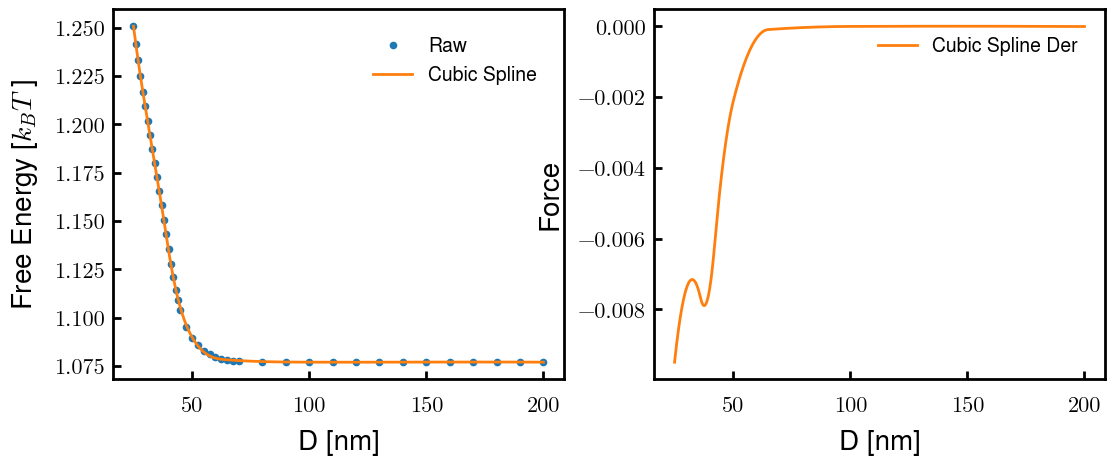

In [9]:
from scipy.interpolate import UnivariateSpline
freeE = pd.read_csv(GIT+'int_NFH.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
d, y = freeE.lx/2, freeE.freeE
max_d = max(d)
min_d = min(d)

## Centered Finite Difference 
# dx  = d.iloc[:-1]  - d.iloc[1:].reset_index(drop=True)
# dxc = (d.iloc[:-1] + d.iloc[1:].reset_index(drop=True)) / 2
# dyc = y.iloc[:-1] - y.iloc[1:].reset_index(drop=True)
# dyc = np.divide(dyc, dx)

## Cubic Splines Interpolater
d_new = np.linspace(min_d, max_d, 1000)
f = UnivariateSpline(d, y, s=1e-5, k=3)
csfit = f(d_new)
csder = f.derivative(n=1)(d_new)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
axs[0].plot(d, y, 'o',   c='C0', label='Raw', ms=4)
axs[0].plot(d_new, csfit, c='C1', label='Cubic Spline')

# axs[1].plot(dxc[0:], dyc[0:], 'o', c='C0', label='Raw cFD',alpha=0.7)
axs[1].plot(d_new, csder,   c='C1', label='Cubic Spline Der')

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()